1

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.display

In [6]:
y, sr = sf.read("/content/speech.wav")
Audio(y, rate=sr)
num_samples = len(y)
duration = num_samples / sr
librosa.resample(y.astype(float), orig_sr=sr, target_sr=16000)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 7.27595761e-12, 3.63797881e-12])

2

In [11]:
import torch
import librosa
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

processor = Wav2Vec2Processor.from_pretrained("Bluecast/wav2vec2-Phoneme")
model = Wav2Vec2ForCTC.from_pretrained("Bluecast/wav2vec2-Phoneme")

if sr != 16000:
    y = librosa.resample(y.astype(float), orig_sr=sr, target_sr=16000)
    sr = 16000

input_values = processor(y, sampling_rate=sr,
return_tensors="pt").input_values

with torch.no_grad():
  logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
phoneme_sequence = processor.batch_decode(predicted_ids)
print("Recognized phoneme sequence:")
print(phoneme_sequence[0])

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

Recognized phoneme sequence:
sh iy jh ah jh d dh ah b l uw p eh n p uh t ih t aa n dh ah t ey b ah l ah n d k w ay ah t l iy w ih s p er d y eh s


3

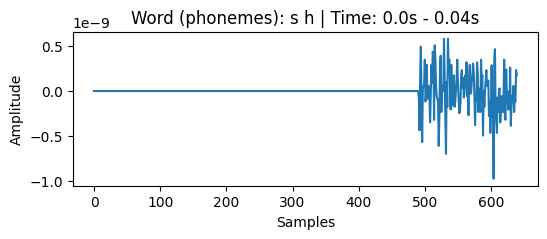

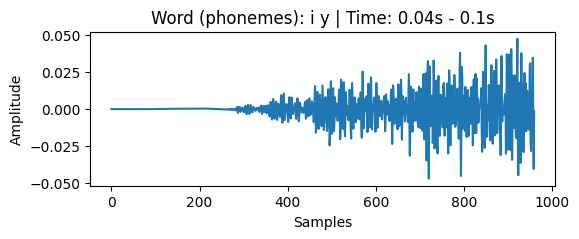

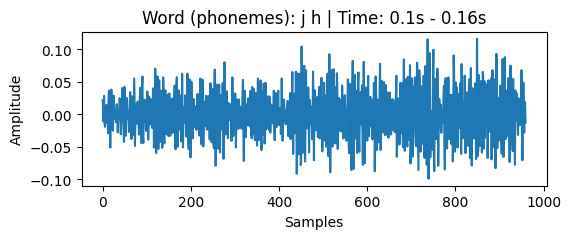

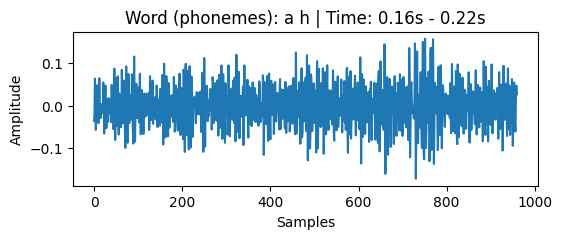

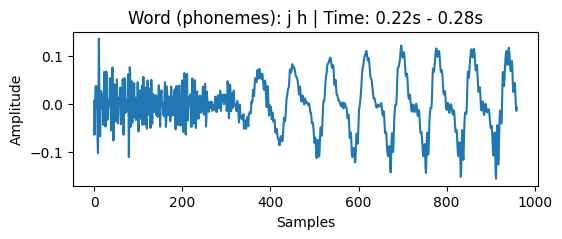

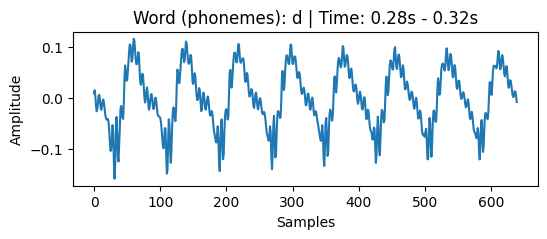

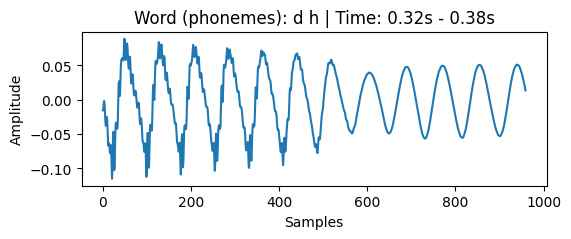

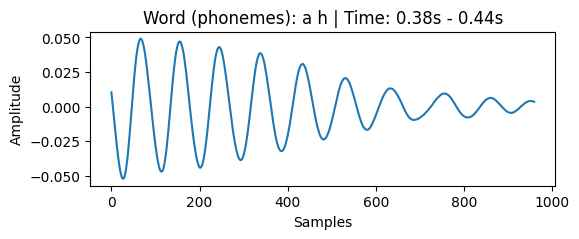

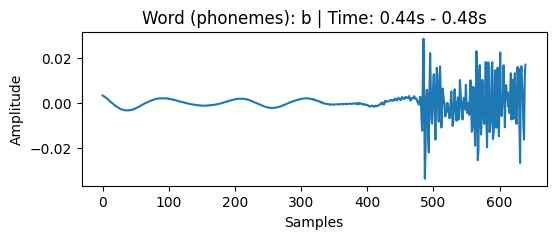

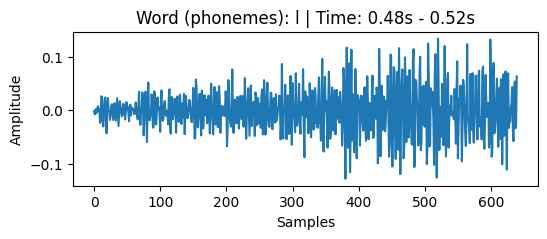

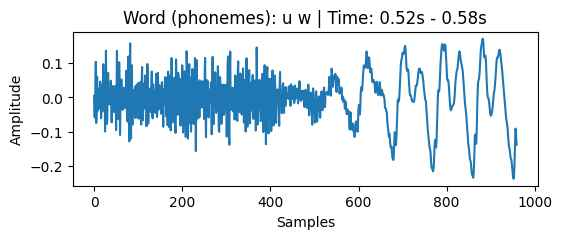

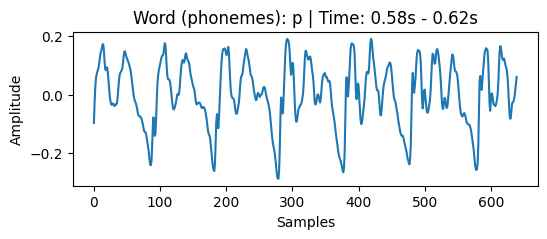

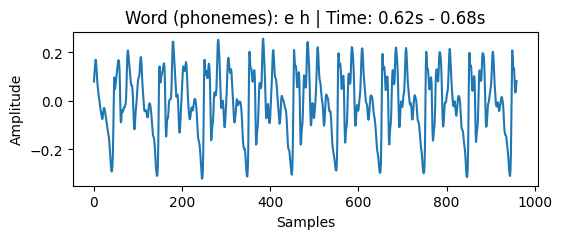

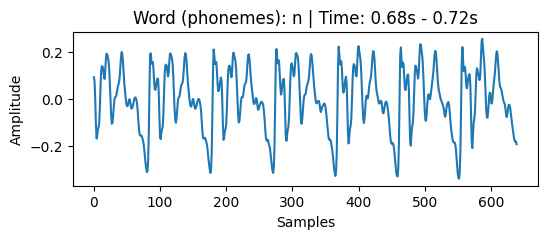

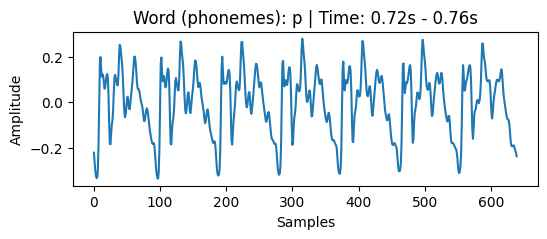

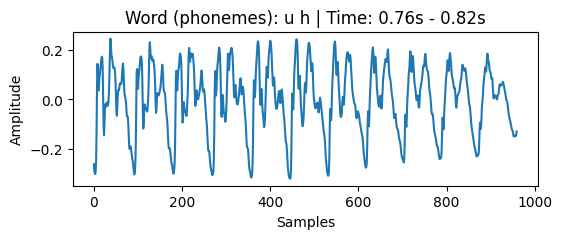

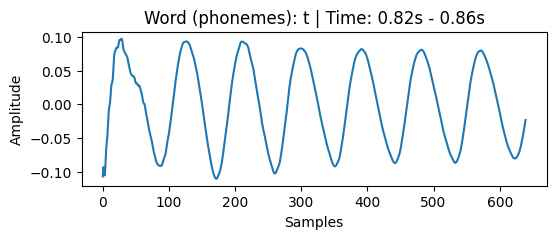

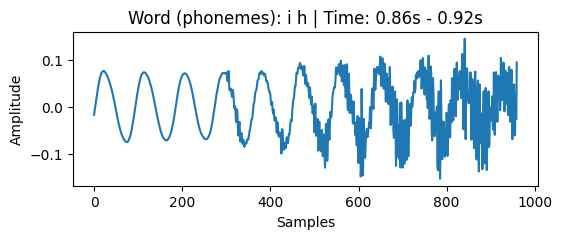

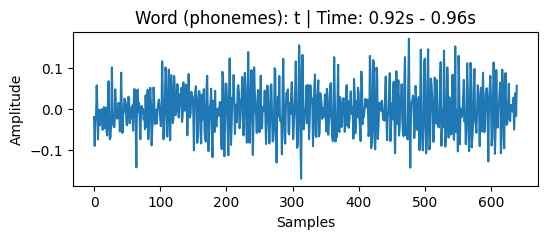

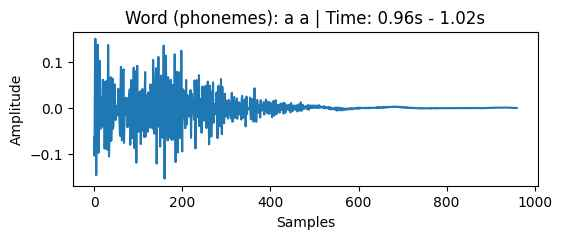

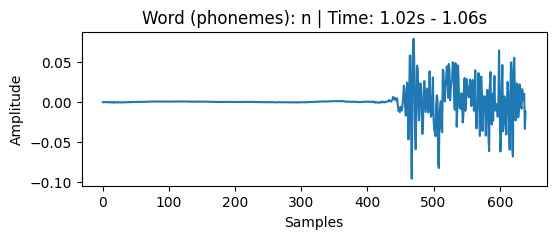

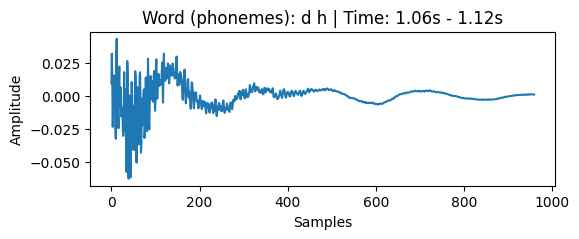

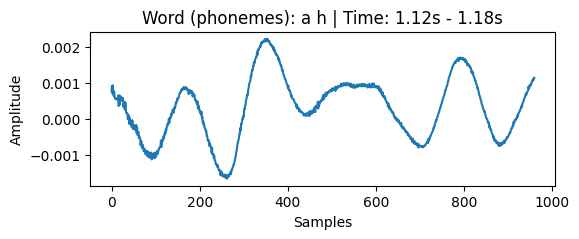

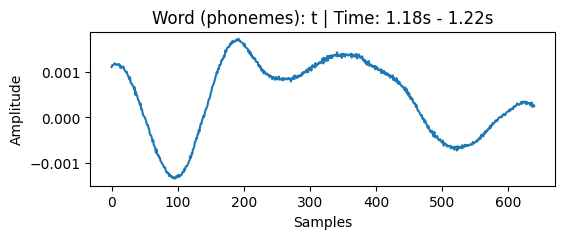

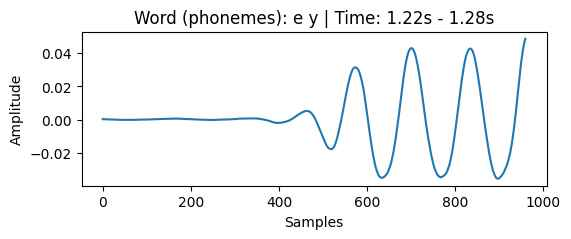

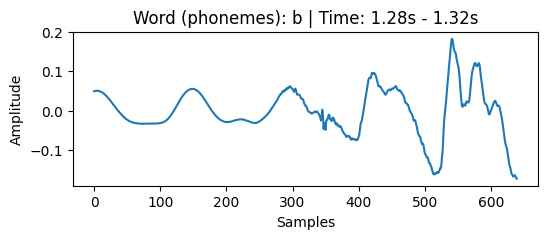

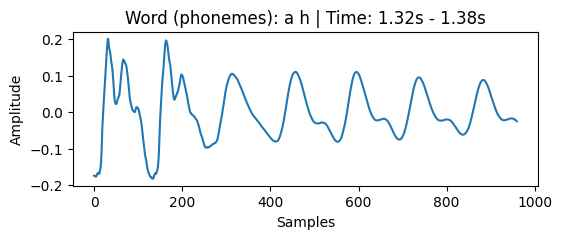

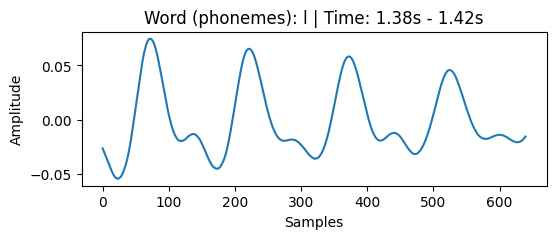

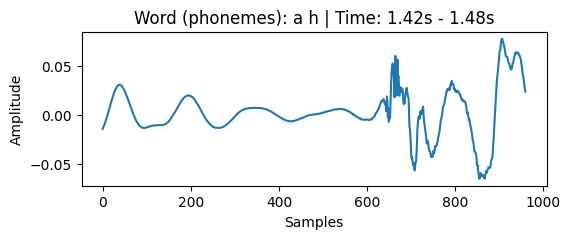

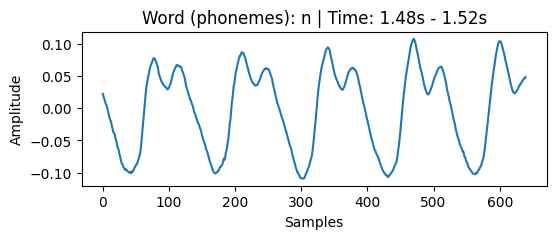

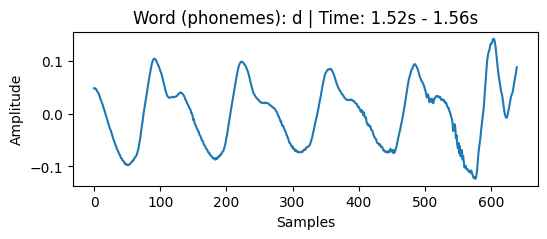

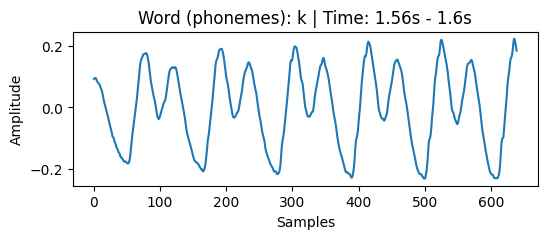

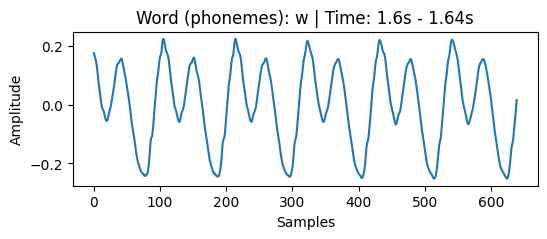

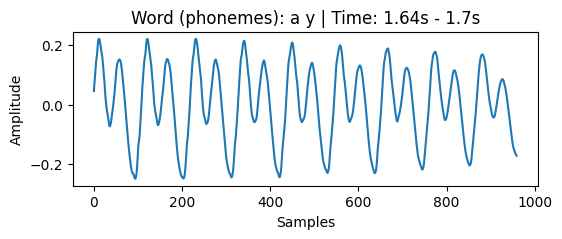

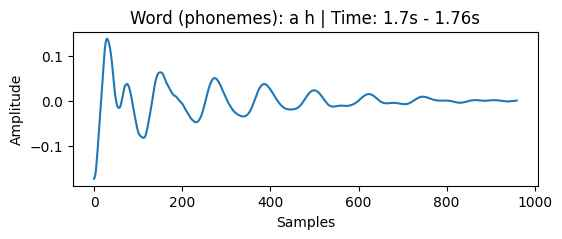

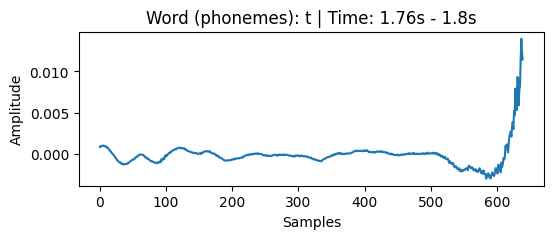

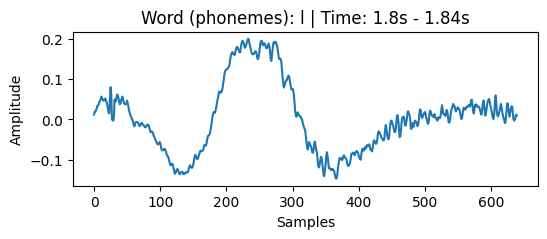

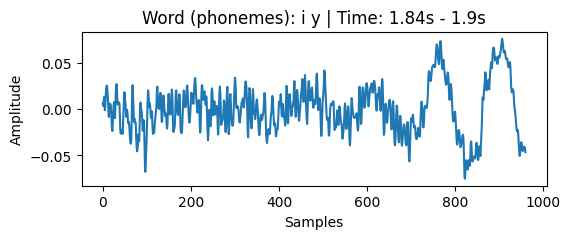

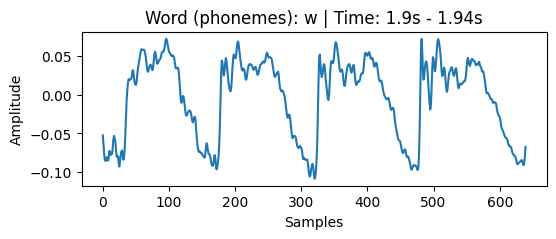

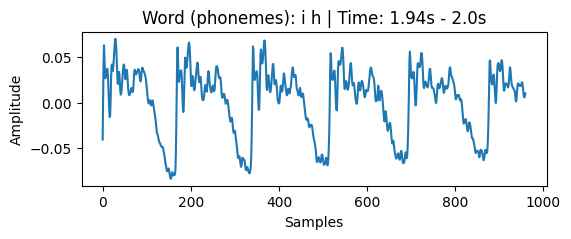

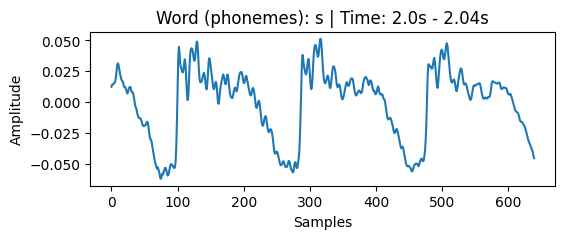

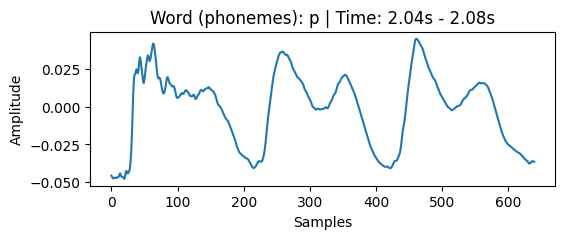

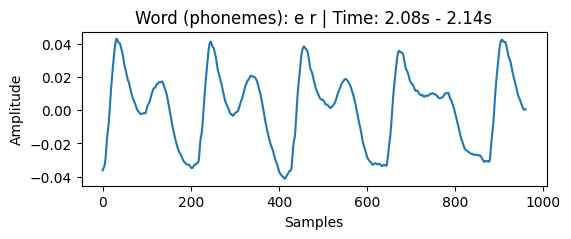

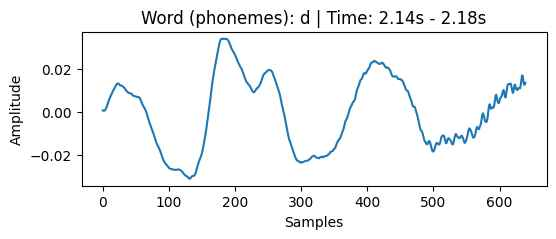

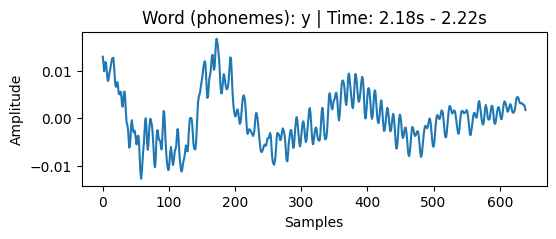

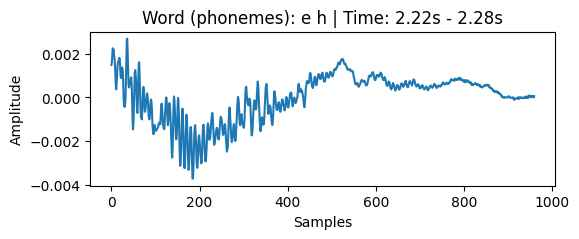

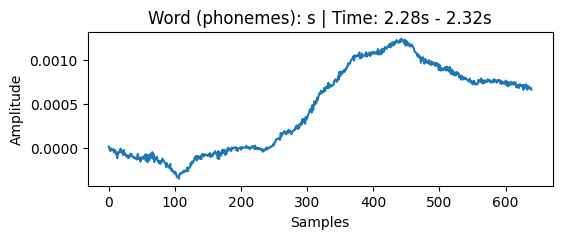

In [13]:
phoneme_sequence_str = processor.batch_decode(predicted_ids)[0]
words = phoneme_sequence_str.strip().split(" ")
frame_ids = torch.argmax(logits, dim=-1)[0].cpu().numpy()
frame_phonemes = processor.batch_decode([frame_ids])[0]
frame_duration = model.config.inputs_to_logits_ratio / sr

segments = []
current_word = []
start_time = 0.0

for i, phoneme in enumerate(frame_phonemes):
    if phoneme == " " or phoneme == "|":
        if current_word:
            end_time = i * frame_duration
            segments.append((" ".join(current_word), start_time,
end_time))
            current_word = []
            start_time = end_time
    else:
        current_word.append(phoneme)
if current_word:
    segments.append((" ".join(current_word), start_time,
len(frame_phonemes) * frame_duration))

for word, start, end in segments:
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    plt.figure(figsize=(6, 2))
    plt.plot(y[start_sample:end_sample])
    plt.title(f"Word (phonemes): {word} | Time: {round(start,2)}s - {round(end,2)}s")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()

4

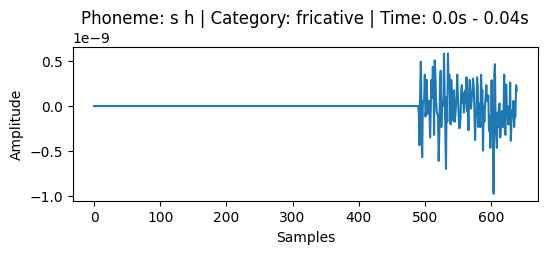

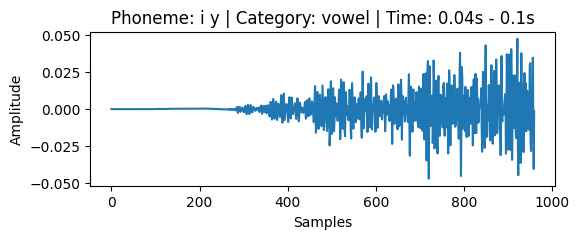

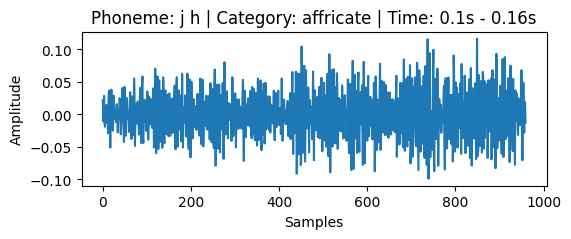

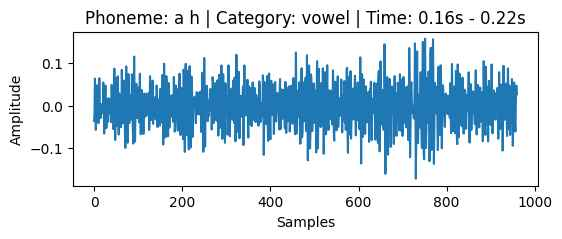

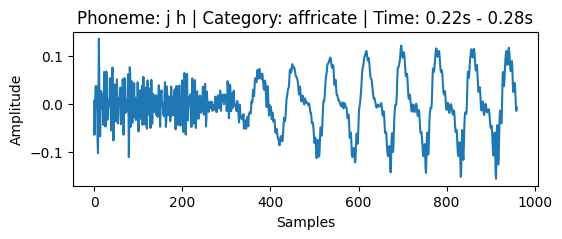

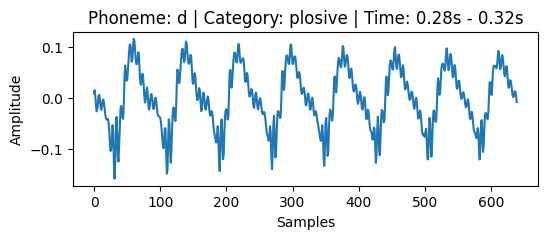

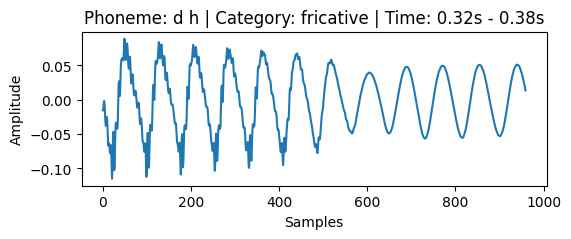

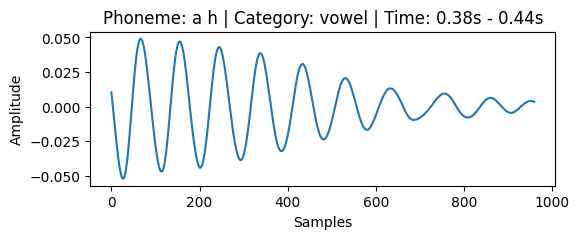

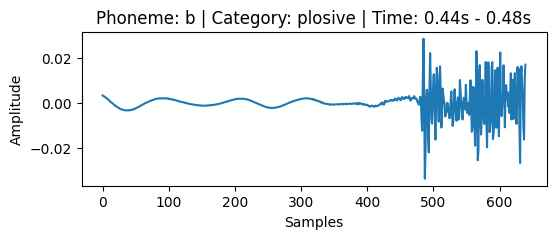

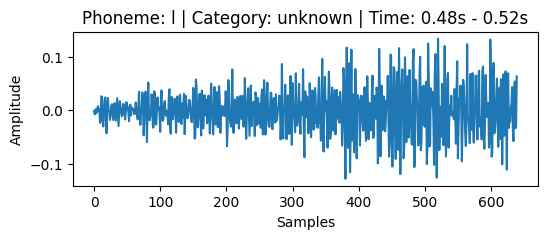

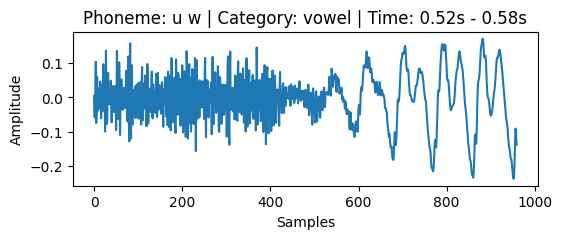

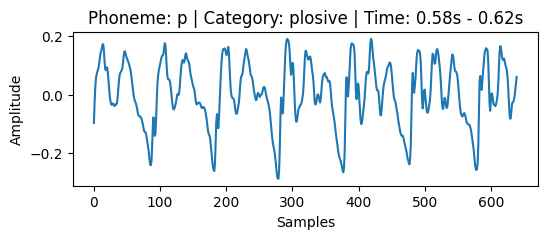

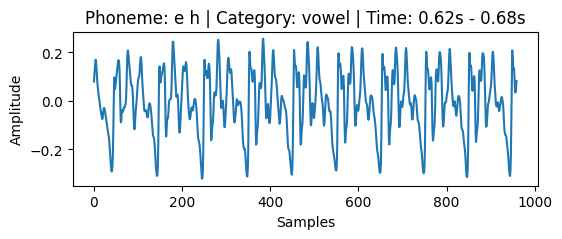

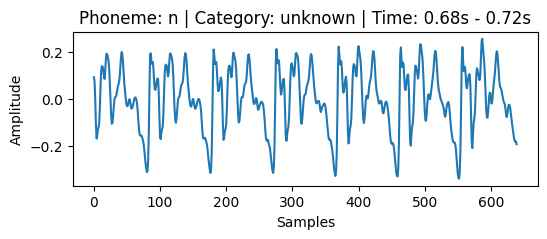

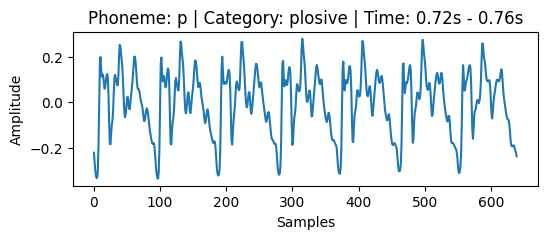

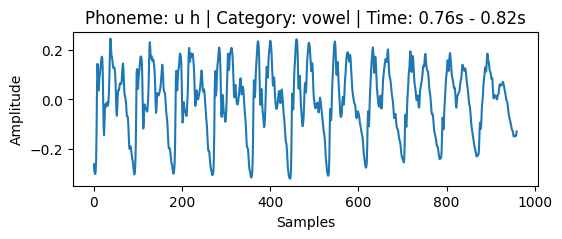

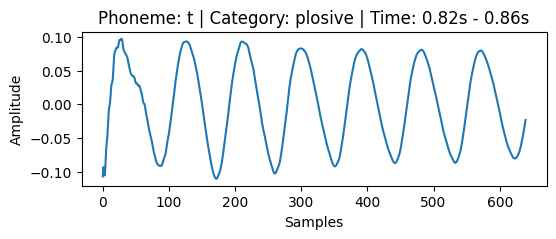

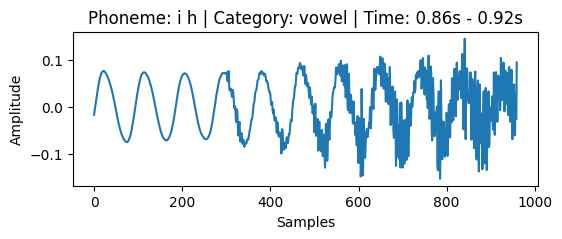

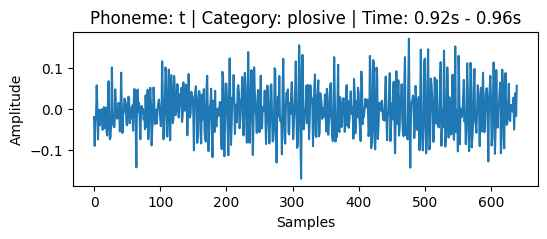

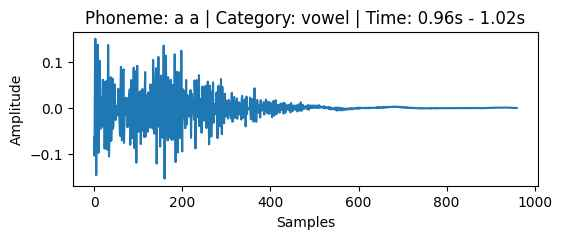

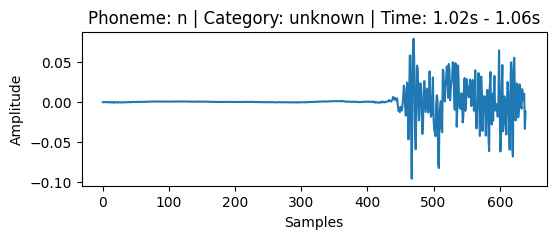

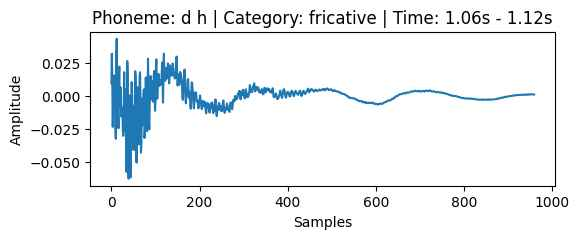

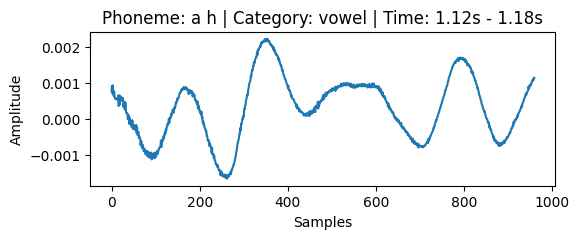

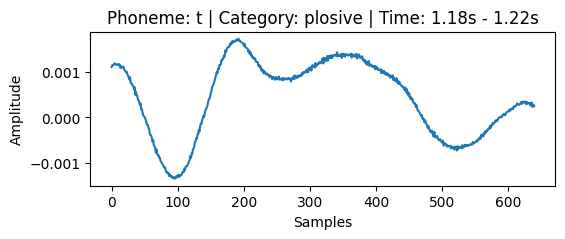

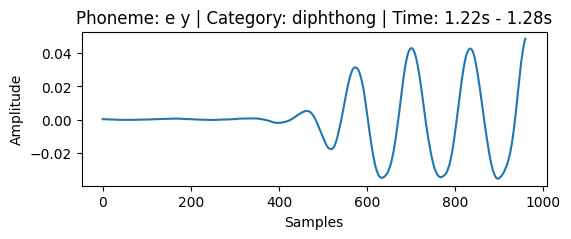

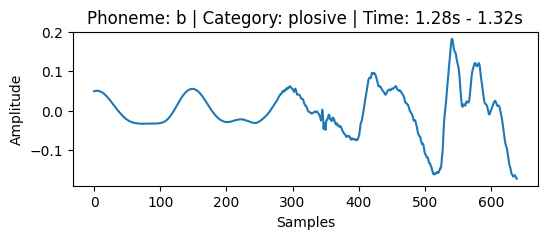

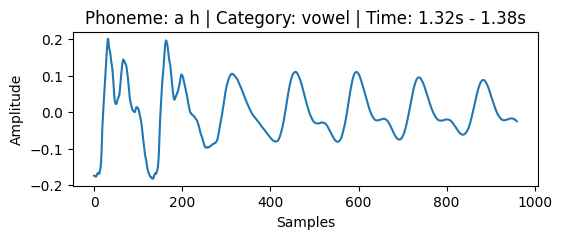

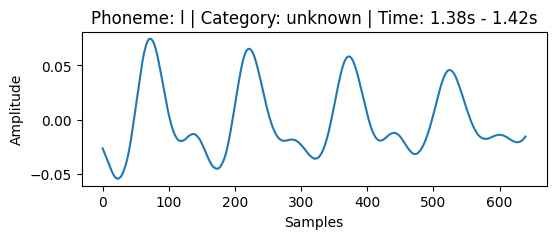

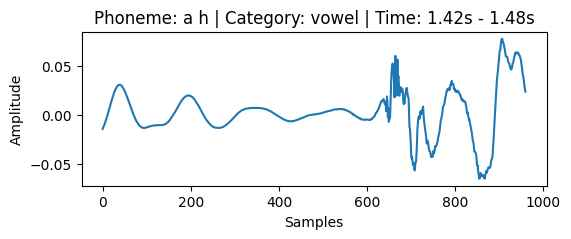

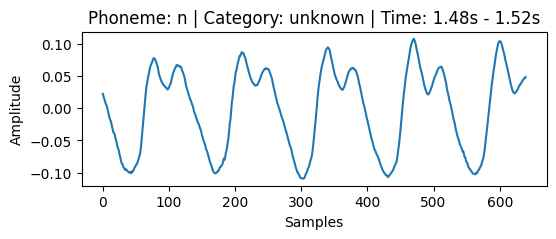

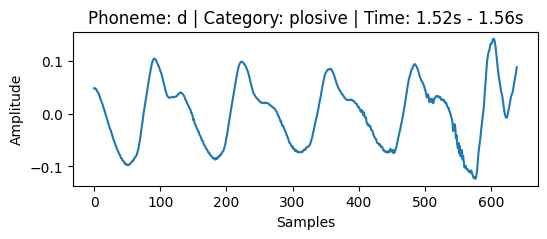

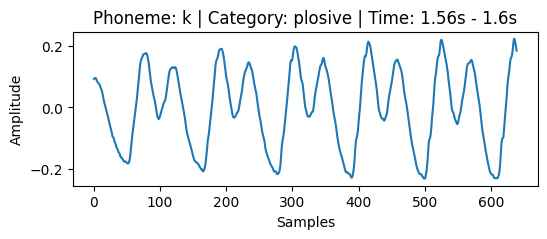

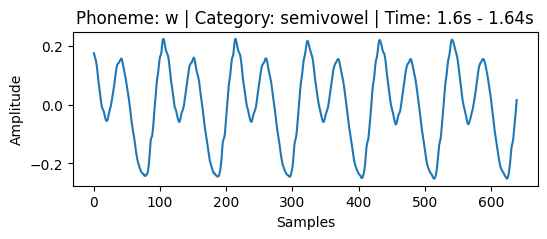

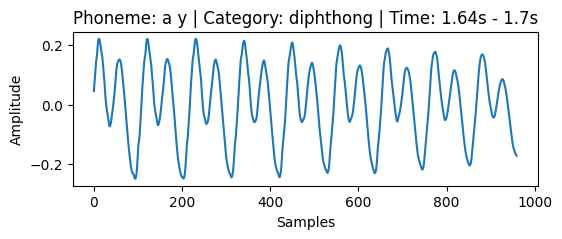

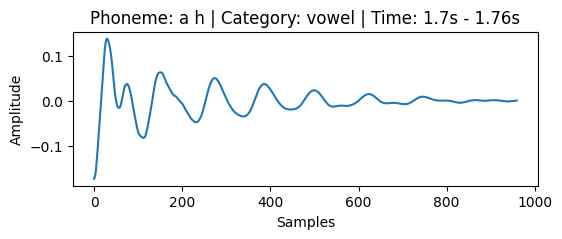

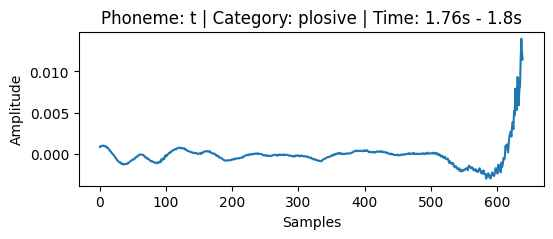

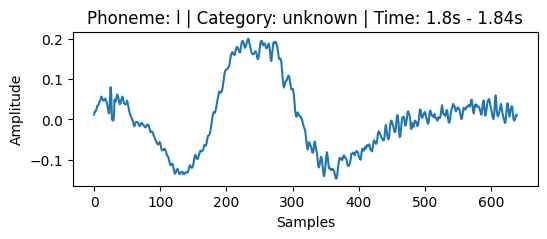

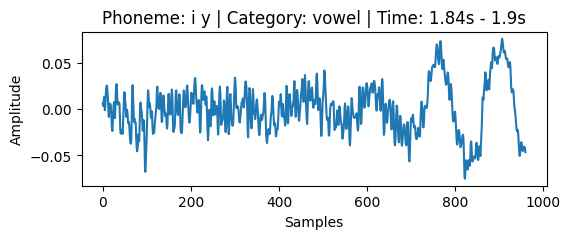

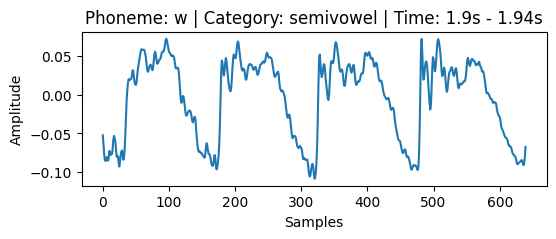

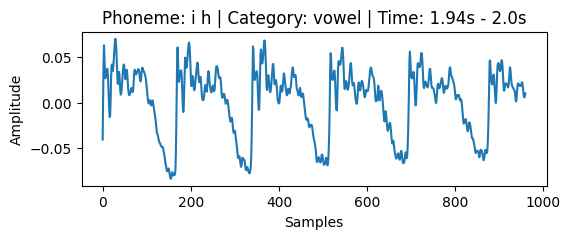

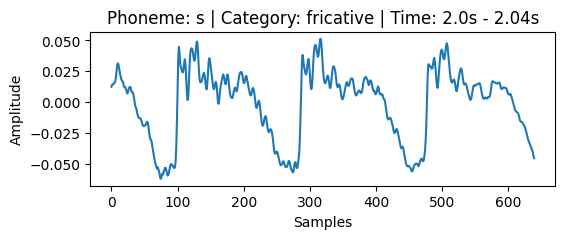

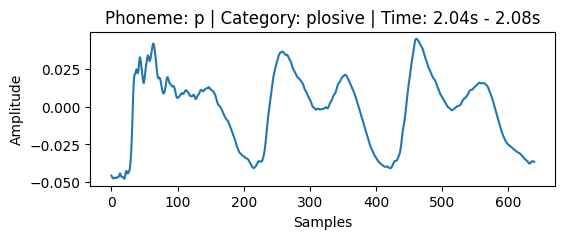

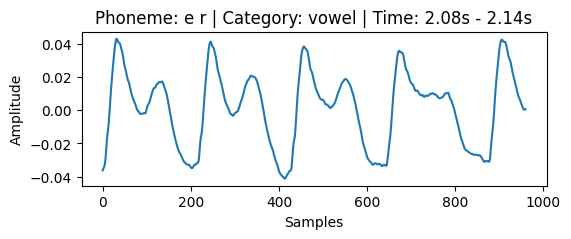

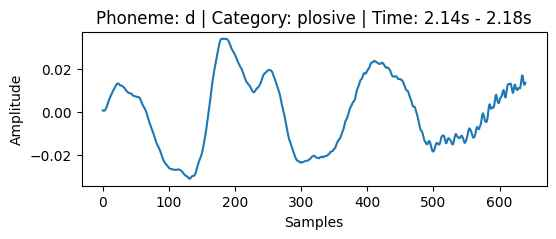

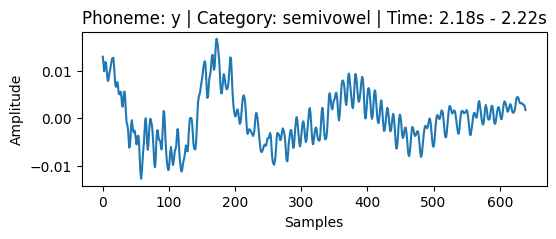

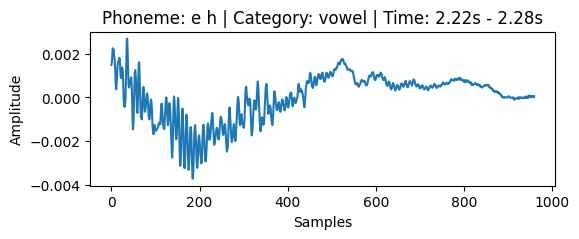

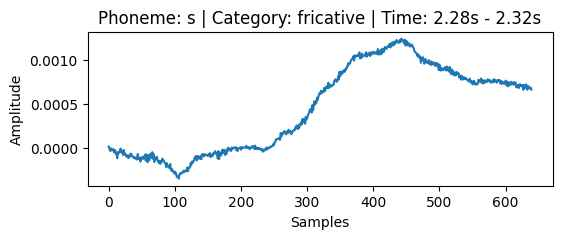

In [17]:
phoneme_categories = {
"vowel": ["a a", "a e", "a h", "a o", "e h", "e r", "i h", "i y", "u h", "u w"],
"plosive": ["p", "b", "t", "d", "k", "g"],
"fricative": ["f", "v", "t h", "d h", "s", "z", "s h", "z h", "h h"],
"affricate": ["c h", "j h"],
"semivowel": ["i", "r", "w", "y"],
"diphthong": ["a y", "e y", "o y", "a w", "o w"],
"whisper": ["s i l", "s p n"]
}
def get_category(phoneme):
  for category, phones in phoneme_categories.items():
    if phoneme in phones:
      return category
  return "unknown"
for phoneme, start, end in segments:
  category = get_category(phoneme)
  start_sample = int(start * sr)
  end_sample = int(end * sr)
  plt.figure(figsize=(6, 2))
  plt.plot(y[start_sample:end_sample])
  plt.title(f"Phoneme: {phoneme} | Category: {category} | Time: {round(start,2)}s - {round(end,2)}s")
  plt.xlabel("Samples")
  plt.ylabel("Amplitude")
  plt.show()

5

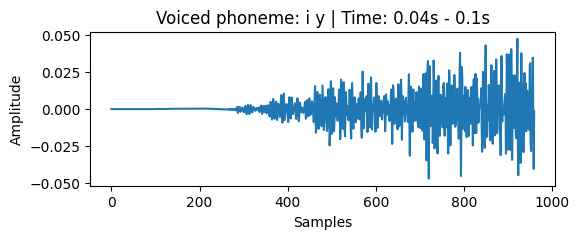

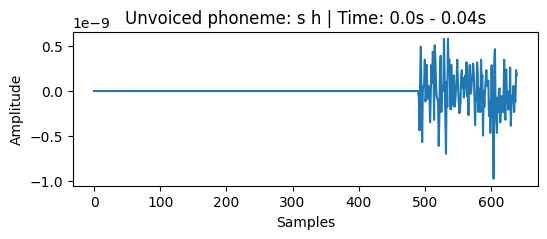

In [19]:
voiced_phonemes = ["a a","a e","a h","a o","e h","e r","i h","i y","u h","u w","b","d","g","v","z","m","n","l","r","w","y","j h"]
unvoiced_phonemes = ["p","t","k","f","s","s h","t h","c h","h h"]

voiced_segment = None
unvoiced_segment = None

for phoneme, start, end in segments:
    if voiced_segment is None and phoneme in voiced_phonemes:
        voiced_segment = (phoneme, start, end)
    if unvoiced_segment is None and phoneme in unvoiced_phonemes:
        unvoiced_segment = (phoneme, start, end)
    if voiced_segment and unvoiced_segment:
        break

for label, segment in [("Voiced", voiced_segment), ("Unvoiced",
unvoiced_segment)]:
    if segment:
        phoneme, start, end = segment
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        plt.figure(figsize=(6, 2))
        plt.plot(y[start_sample:end_sample])
        plt.title(f"{label} phoneme: {phoneme} | Time: {round(start,2)}s - {round(end,2)}s")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

objective 2

(i)

In [21]:
import soundfile as sf
import librosa
y, sr = sf.read("/content/speech (1).wav")
print("Original sample rate:", sr)
print("Original shape:", y.shape)
if y.ndim > 1:
  y = librosa.to_mono(y.T)
if sr != 16000:
  y = librosa.resample(y.astype(float), orig_sr=sr, target_sr=16000)
  sr = 16000
print("Resampled sample rate:", sr)
print("Number of samples:", len(y))
print("Duration (sec):", round(len(y)/sr, 3))

Original sample rate: 24000
Original shape: (36288,)
Resampled sample rate: 16000
Number of samples: 24192
Duration (sec): 1.512


(ii)

In [23]:
import soundfile as sf
import librosa
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import matplotlib.pyplot as plt

processor = Wav2Vec2Processor.from_pretrained("Bluecast/wav2vec2-Phoneme")
model = Wav2Vec2ForCTC.from_pretrained("Bluecast/wav2vec2-Phoneme")

input_values = processor(y, sampling_rate=sr,
return_tensors="pt").input_values
with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
phoneme_sequence = processor.batch_decode(predicted_ids)

print("Recognized phoneme sequence:")
print(phoneme_sequence[0])

frame_ids = torch.argmax(logits, dim=-1)[0].cpu().numpy()
frame_phonemes = processor.batch_decode([frame_ids])[0]

frame_duration = model.config.inputs_to_logits_ratio / sr
segments = []
current_phoneme = frame_phonemes[0]
start_time = 0.0

for i, phoneme in enumerate(frame_phonemes[1:], start=1):
    if phoneme != current_phoneme:
        end_time = i * frame_duration
        segments.append((current_phoneme, start_time, end_time))
        current_phoneme = phoneme
        start_time = end_time

segments.append((current_phoneme, start_time, len(frame_phonemes) *
frame_duration))

print("Number of phoneme segments:", len(segments))

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

Recognized phoneme sequence:
sh iy s iy z y uw
Number of phoneme segments: 17


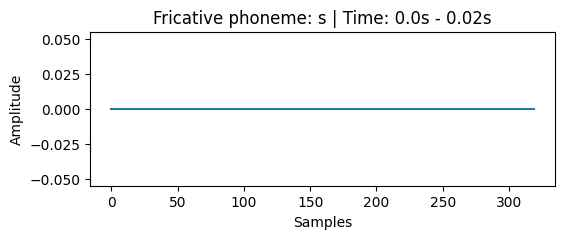

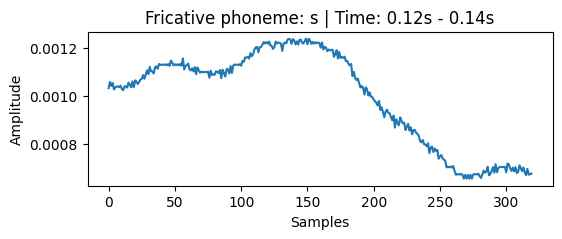

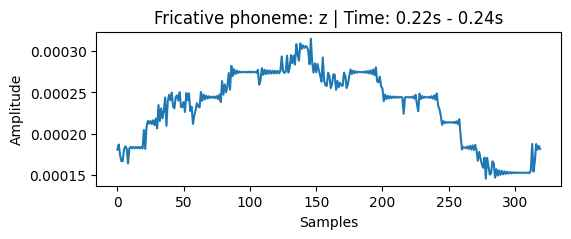

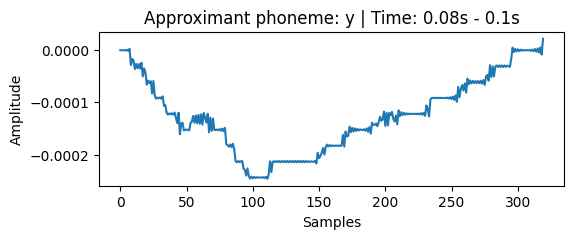

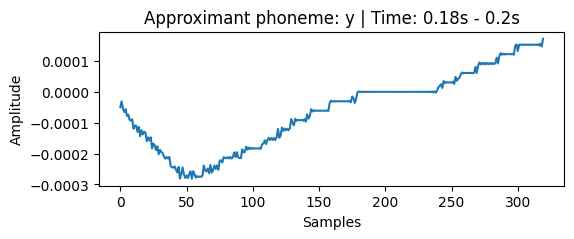

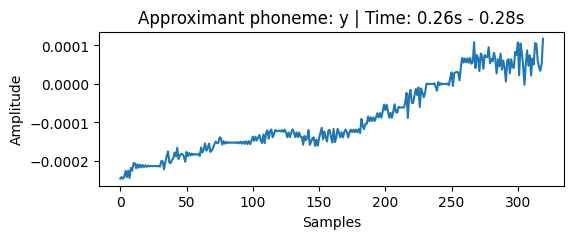

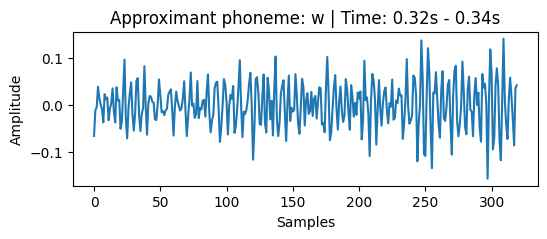

In [27]:
phoneme_categories = {
    "vowel": ["a a", "a e", "a h", "a o", "e h", "e r", "i h", "i y","u h", "u w"],
    "plosive": ["p", "b", "t", "d", "k", "g"],
    "fricative": ["f", "v", "t h", "d h", "s", "z", "s h", "z h", "h h"],
    "affricate": ["c h", "j h"],
    "semivowel": ["l", "r", "w", "y"],
    "diphthong": ["a y", "e y", "o y", "a w", "o w"],
    "whisper": ["s i l", "s p n"]
}

def get_category(phoneme):
    for category, phones in phoneme_categories.items():
        if phoneme in phones:
            return category
    return "unknown"

fricative_segments = []
approximant_segments = []

for phoneme, start, end in segments:
    category = get_category(phoneme)
    if category == "fricative":
        fricative_segments.append((phoneme, start, end))
    elif category == "semivowel":
        approximant_segments.append((phoneme, start, end))

for phoneme, start, end in fricative_segments:
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    plt.figure(figsize=(6, 2))
    plt.plot(y[start_sample:end_sample])
    plt.title(f"Fricative phoneme: {phoneme} | Time: {round(start,2)}s - {round(end,2)}s")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()

for phoneme, start, end in approximant_segments:
  start_sample = int(start * sr)
  end_sample = int(end * sr)
  plt.figure(figsize=(6, 2))
  plt.plot(y[start_sample:end_sample])
  plt.title(f"Approximant phoneme: {phoneme} | Time: {round(start,2)}s - {round(end,2)}s")
  plt.xlabel("Samples")
  plt.ylabel("Amplitude")
  plt.show()

(iii)

In [29]:
fricatives = ['s', 'z', 'sh']
approximants = ['y']

fricative_segments = []
approximant_segments = []

for phoneme, start, end in segments:
  if phoneme in fricatives:
    fricative_segments.append((phoneme, start, end))
  elif phoneme in approximants:
    approximant_segments.append((phoneme, start, end))
print("Fricative Segments:",fricative_segments)
print("Approximant Segments:",approximant_segments)

Fricative Segments: [('s', 0.0, 0.02), ('s', 0.12, 0.14), ('z', 0.22, 0.24)]
Approximant Segments: [('y', 0.08, 0.1), ('y', 0.18, 0.2), ('y', 0.26, 0.28)]


(iv)

In [31]:
def extract_segment(signal, sr, start, end):
  return signal[int(start * sr): int(end * sr)]
fricative_signals = [(ph, extract_segment(y, sr, st, et)) for ph, st, et in fricative_segments]
approximant_signals = [(ph, extract_segment(y, sr, st, et)) for ph, st, et in approximant_segments]

print("fractive segments",fricative_signals)
print("pproximant segments",approximant_signals)

fractive segments [('s', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


(v)

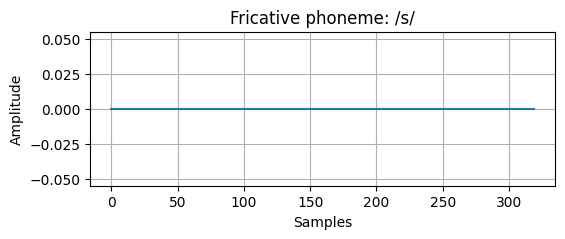

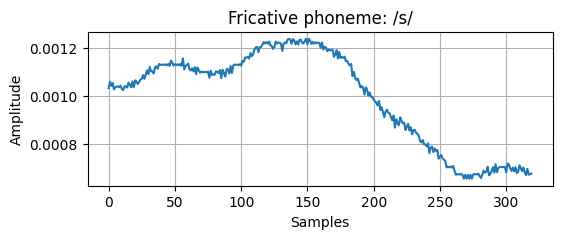

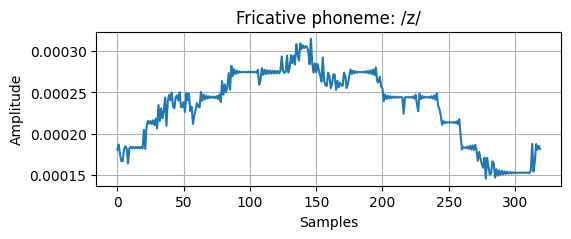

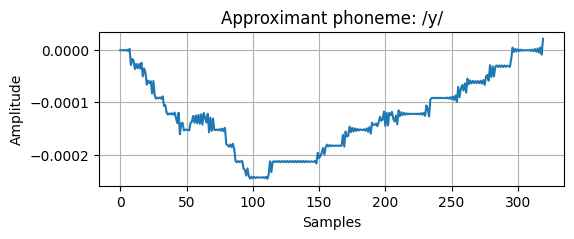

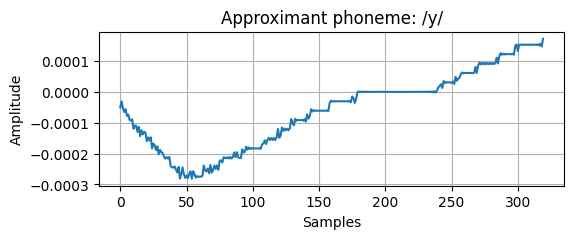

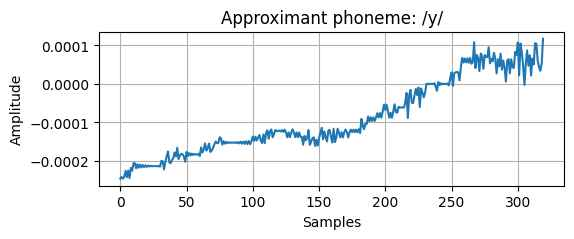

In [32]:
def plot_segments(segments, title):
  for ph, sig in segments:
    plt.figure(figsize=(6,2))
    plt.plot(sig)
    plt.title(f"{title} phoneme: /{ph}/")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
plot_segments(fricative_signals, "Fricative")
plot_segments(approximant_signals, "Approximant")